In [1]:
%%time
import pyfesom2 as pf
import xarray as xr
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter

import pandas as pd
import gc
import shutil
import os
import matplotlib.tri as mtri
import cmocean
from datetime import datetime, date, timedelta 

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cart
from scipy.interpolate import NearestNDInterpolator

from dask.distributed import Client
import dask
from dask.distributed import Client
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status'})

osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.
CPU times: user 3.62 s, sys: 2.62 s, total: 6.24 s
Wall time: 3.11 s


In [2]:
dep = 70
yy=2017
dd=274
#dd=213
#yy = 2020
#mon = 3
#day = 15
#dd = 75

savefig=True
# converting to date string
date_string = datetime.strptime(str(yy) + "-" + str(dd), "%Y-%j").strftime("%Y_%m_%d") 

In [3]:
res = 'ultra' #'ultra','high','low'

In [4]:
# chunk sizes
vertical_split = 1
time_split = 1

In [5]:
#paths 
data_path = '/p/scratch/chhb19/mueller29/AO_40_nopc/'
mesh_path = '/p/project/chhb19/meshes/AO_40/'
plot_path  = '/p/home/jusers/mueller29/juwels/EPICA/plots/figures_paper/'
out_path = '/p/scratch/chhb19/mueller29/maps/'

In [6]:
#the right depth level
z1 = xr.open_dataset(data_path+'unod.fesom.2015.nc').coords['nz1'] 
iz1 = np.argmin(np.abs((z1-dep).values))

In [7]:
speed_file = out_path+'speed_gridded_daily_'+date_string+'_'+str(dep)+'.npz'
# load mesh and rotate to equator
mesh = pf.load_mesh(mesh_path)
elements = mesh.elem.astype("int32")
lons = mesh.x2
lats = mesh.y2

# for ice interpolate without rotation with lower resolution
d = lons[elements].max(axis=1) - lons[elements].min(axis=1)
no_cyclic_elem = np.argwhere(d < 100).ravel()
triang_ice = mtri.Triangulation(lons, lats, elements[no_cyclic_elem])
fn_ice = data_path+'a_ice.fesom.'+str(yy)+'.nc'
ds_ice = xr.open_dataset(fn_ice, chunks={"time": time_split, "nz1": vertical_split})["a_ice"].astype("float32")[dd-1,:]
depth = -xr.open_dataset((mesh_path+'fesom.mesh.diag.nc'))['zbar_n_bottom'].astype('float32')


if not os.path.exists(speed_file):
    fn_u = data_path+'unod.fesom.'+str(yy)+'.nc'
    fn_v = data_path+'vnod.fesom.'+str(yy)+'.nc'
    

    ds_u = xr.open_dataset(fn_u, chunks={'time': time_split,'nz1':vertical_split})['unod'].astype('float32')[dd-1,iz1,:]
    ds_v = xr.open_dataset(fn_v, chunks={'time': time_split,'nz1':vertical_split})['vnod'].astype('float32')[dd-1,iz1,:]
    

    speed = np.sqrt(ds_u**2+ds_v**2).drop_vars('nz1')
    

    
    # define euler angles
    alpha = -90
    beta = 90
    gamma = 90
    lons_rot, lats_rot = pf.ut.scalar_g2r(alpha, beta, gamma, lons,lats)
    d = lons_rot[elements].max(axis=1) - lons_rot[elements].min(axis=1)
    no_cyclic_elem = np.argwhere(d < 100).ravel()
    triang = mtri.Triangulation(lons_rot, lats_rot, elements[no_cyclic_elem])

    # region
    left = -180
    right = 180
    south = 70
    north = 90
    
    dx = 0.01
    dy = 0.01

    nx2 = (
        north - south + dx
    )  # just to make sure the grid isn't square (makes it easier to keep track of dimensions)
    ny2 = north - south
    lon_reg = np.arange(-nx2, nx2, dx)
    lat_reg = np.arange(-ny2, ny2, dy)
    xx_eq, yy_eq = np.meshgrid(lon_reg, lat_reg)
    xx_eq = xx_eq.T
    yy_eq = yy_eq.T
    xx_pol, yy_pol = pf.ut.scalar_r2g(
        alpha, beta, gamma, xx_eq, yy_eq
    )  # regular grid from equator rotated to North (for loading mask)
    tri = triang.get_trifinder()
    
    speed_grid = mtri.LinearTriInterpolator(triang, speed, trifinder=tri)(xx_eq, yy_eq)
    speed_grid[np.where(speed_grid == 0)] = np.nan
    
    
    #save stuff
    np.savez_compressed(speed_file,xx_pol=xx_pol, yy_pol=yy_pol,speed_grid=speed_grid)
    

else:
    speed_stuff = np.load(speed_file)
    xx_pol = speed_stuff['xx_pol']
    yy_pol = speed_stuff['yy_pol']
    speed_grid = speed_stuff['speed_grid']  

/p/project/chhb19/meshes/AO_40/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/meshes/AO_40/pickle_mesh_py3_fesom2


In [8]:
o_path = '/p/project/chhb19/mueller29/data_EKE_paper/'
t=ds_ice.time.values
dout = xr.Dataset(
    data_vars=dict(
        speed=(['x', 'y'], speed_grid),
    ),
    coords=dict(
        XX=(['x', 'y'], xx_pol),
        YY=(['x', 'y'], yy_pol),
        time=(t),
    ),
    attrs=dict(
        description="speed at "+str(dep)+" m",
        units="m/s",
    ),
)     
dout.to_netcdf((o_path+'Fig1_speed_snapshot'+str(dep)+'m.nc'))


PermissionError: [Errno 13] Permission denied: b'/p/project/chhb19/mueller29/data_EKE_paper/Fig1_speed_snapshot70m.nc'

In [9]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [10]:
os.environ["CARTOPY_USER_BACKGROUNDS"] = "/p/home/jusers/mueller29/juwels/background_img/"

In [11]:
lon_start = 72.9
lon_end = 111.3
lat_start = 83.5
lat_end = 81.8
lonlat=pf.transect_get_lonlat(lon_start, lat_start, lon_end, lat_end,npoints=500)

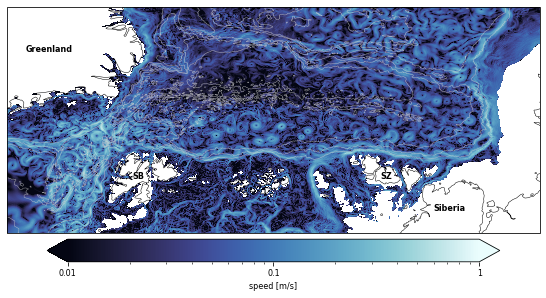

In [12]:
%matplotlib inline
ddd=1
fn_out = plot_path+'F1_snap_'+date_string+'_with_bathy.png'

cm2in = 1/2.54  # centimeters in inches

#figsize = (9.5*cm2in, 11.5*cm2in) #1/4 page
figsize = (19*cm2in, 11.5*cm2in) #1/2 page

fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.RotatedPole(pole_longitude=240.0, pole_latitude=45.0, central_rotated_longitude=0.0)),
            constrained_layout=True,
            figsize=figsize,
        )

ax.set_extent([-50,170,77,90], crs=ccrs.PlateCarree())

ax.coastlines(resolution='50m',linewidths=.5)
image = ax.pcolormesh(xx_pol[::ddd,::ddd],yy_pol[::ddd,::ddd],speed_grid[::ddd,::ddd], cmap = cmocean.cm.ice, norm=colors.LogNorm(vmin=1e-2, vmax=1), shading='auto',transform=ccrs.PlateCarree())


cont2 = ax.tricontour(
    triang_ice,
    depth,
    [1000,2000,3000,4000,5000],
    transform=ccrs.PlateCarree(),
    colors='lightgrey',
    linewidths=.5,
    alpha=.7
)


formatter = LogFormatter(10, labelOnlyBase=False) 
cb = fig.colorbar(image, ticks=[0.01,0.1,1], format=formatter, orientation='horizontal', ax=ax, pad=0.02, shrink=0.85, extend='both')

cb.ax.set_xticklabels(['0.01', '0.1', '1'])  # vertically oriented colorbar
cb.set_label('speed [m/s]')



tt=ax.text(.035, .8, 'Greenland',zorder=100, transform=ax.transAxes, size=SMALL_SIZE,color='k', weight='bold')
tt.set_bbox(dict(facecolor='white', alpha=.5, edgecolor='none',pad=0))
tt=ax.text(.235, .24, 'SB',zorder=100, transform=ax.transAxes, size=SMALL_SIZE,color='k', weight='bold')
tt.set_bbox(dict(facecolor='white', alpha=.5, edgecolor='none',pad=0))
#tt=ax.text(.45, .2, 'FL',zorder=100, transform=ax.transAxes, size=SMALL_SIZE,color='k', weight='bold')
#tt.set_bbox(dict(facecolor='white', alpha=.5, edgecolor='none',pad=0))
tt=ax.text(.7, .24, 'SZ',zorder=100, transform=ax.transAxes, size=SMALL_SIZE,color='k', weight='bold')
tt.set_bbox(dict(facecolor='white', alpha=.5, edgecolor='none',pad=0))
tt=ax.text(.8, .1, 'Siberia',zorder=100, transform=ax.transAxes, size=SMALL_SIZE,color='k', weight='bold')
tt.set_bbox(dict(facecolor='white', alpha=.5, edgecolor='none',pad=0))



if savefig:
    #fig.set_figwidth(9.5, forward=True)
    fig.savefig(fn_out,dpi=400,format='png',bbox_inches='tight',pad_inches=0)


In [13]:
fn_out

'/p/home/jusers/mueller29/juwels/EPICA/plots/figures_paper/F1_snap_2017_10_01_with_bathy.png'

In [ ]:
%matplotlib inline
ddd=1
fn_out = plot_path+'F1_snap_'+date_string+'_no_bathy.png'
figsize = (9.5, 11.5) #1/4 page

fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.RotatedPole(pole_longitude=240.0, pole_latitude=45.0, central_rotated_longitude=0.0)),
            constrained_layout=True,
            figsize=figsize,
        )

ax.set_extent([-50,170,77,90], crs=ccrs.PlateCarree())

#ax.background_img(name='BM', resolution='high',extent=[-180,180,65,90], cache=True)
ax.coastlines(resolution='50m')
image = ax.pcolormesh(xx_pol[::ddd,::ddd],yy_pol[::ddd,::ddd],speed_grid[::ddd,::ddd], cmap = cmocean.cm.ice, norm=colors.LogNorm(vmin=1e-2, vmax=1), shading='auto',transform=ccrs.PlateCarree())


# cont = ax.tricontour(
#     triang_ice,
#     ds_ice,
#     [0.15],
#     transform=ccrs.PlateCarree(),
#     colors='k',
#     linewidths=2,
# )
line=ax.plot(lonlat[0,:],lonlat[1,:],'k',linewidth=1, transform=ccrs.PlateCarree())

formatter = LogFormatter(10, labelOnlyBase=False) 
cb = fig.colorbar(image, ticks=[0.01,0.1,1], format=formatter, orientation='horizontal', ax=ax, pad=0.02, shrink=0.85, extend='both')

cb.ax.set_xticklabels(['0.01', '0.1', '1'])  # vertically oriented colorbar
cb.set_label('speed [m/s]')

#if savefig:
#    fig.set_figwidth(9.5, forward=True)
#    fig.savefig(fn_out,dpi=600,format='png',bbox_inches='tight')
